# Problem
For the March edition of the 2022 Tabular Playground Series you're challenged to forecast twelve-hours of traffic flow in a U.S. metropolis. The time series in this dataset are labelled with both location coordinates and a direction of travel -- a combination of features that will test your skill at spatio-temporal forecasting within a highly dynamic traffic network.



## Imports and reading the data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

DATA_FOLDER = "./data/"

traindf = pd.read_csv(DATA_FOLDER + "train.csv")
testdf = pd.read_csv(DATA_FOLDER + "test.csv")

traindf.head()

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60


The training data is given as a dataframe as seen above. We have a coordinate point in a 2D space given as an (x, y) point. The congestion of traffic is given to a certain direction with a value between 0-100, where 100 means heavy traffic.

## Data analysis and plotting

Let's first see if there are any missing values in the dataset.

In [2]:
traindf.isna().sum()

row_id        0
time          0
x             0
y             0
direction     0
congestion    0
dtype: int64

No missing values are present. Let's analyze the data a bit more.

In [3]:
traindf.describe()

,row_id,x,y,congestion
count,848835.000000,848835.000000,848835.000000,848835.000000
mean,424417.000000,1.138462,1.630769,47.815305
std,245037.702211,0.801478,1.089379,16.799392
min,0.000000,0.000000,0.000000,0.000000
25%,212208.500000,0.000000,1.000000,35.000000
50%,424417.000000,1.000000,2.000000,47.000000
75%,636625.500000,2.000000,3.000000,60.000000
max,848834.000000,2.000000,3.000000,100.000000


We have a total of 848 835 data points. There are 12 coordinate points with x ranging from 0-2 and y ranging from 0-3.

My first approach was to ignore the day of traffic entirely and solely focus on the time of the day. Let's add a timestamp column to the training and testing data that ignores the day.

In [4]:
traindf["timestamp"] = pd.to_datetime(traindf["time"]).dt.time
testdf["timestamp"] = pd.to_datetime(testdf["time"]).dt.time

Let's study one of the coordinate points a bit more. Here I have plotted the congestion of traffic w.r.t time ignoring the day.

Text(0, 0.5, 'Congestion')

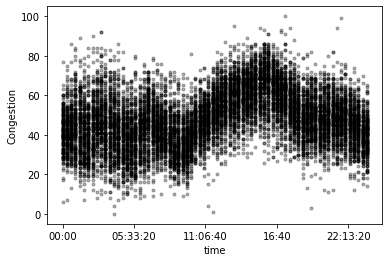

In [5]:
plotdf = traindf[(traindf["x"] == 1) & (traindf["y"] == 1) & (traindf["direction"] == "NB")]

fig, ax = plt.subplots()
ax.plot(plotdf["timestamp"], plotdf["congestion"], ".", color="black", alpha=0.3)
ax.set_ylabel("Congestion")

We can see that there's sort of a trend. Let's plot the mean values of each timestamp to the figure.

Text(0, 0.5, 'Congestion')

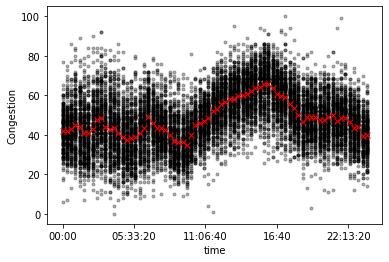

In [6]:
meandf = plotdf.groupby(["timestamp", "direction", "x", "y"], as_index=False)["congestion"].mean()

fig, ax = plt.subplots()
ax.plot(plotdf["timestamp"], plotdf["congestion"], ".", color="black", alpha=0.3)
ax.plot(meandf["timestamp"], meandf["congestion"], "x", color="red")
ax.set_ylabel("Congestion")

## Results

Now, the plan is to get the mean value of a timestamp and add that to the testing data.

In [11]:
# Initialize a dataframe for the results
resultdf = pd.DataFrame(columns=["timestamp", "direction", "congestion"])

# Loop through the coordinate points
for x in range(0, 3):
    for y in range(0, 4):
        
        # Not all coordinate points have a traffic flow to all directions, so we need a direction list of the coordinate point
        dir_list = traindf[(traindf["x"] == x) & (traindf["y"] == y)]["direction"].unique()
        
        # Loop through the directions
        for direction in dir_list:
            
            # Create a dataframe that has all of the congestion values for a certain coordinate point and a certain direction
            df1 = traindf[(traindf["x"] == x) & (traindf["y"] == y) & (traindf["direction"] == direction)]
            
            # Calculate the mean value of the congestion at a certain coordinate point and to a certain direction
            meandf = df1.groupby(["timestamp", "direction", "x", "y"], as_index=False)["congestion"].mean()
            
            # Append to the result df
            resultdf = resultdf.append(meandf, ignore_index=True)            

# Change the coordinate points from float64 to int64
resultdf["x"] = resultdf["x"].astype(np.int64)
resultdf["y"] = resultdf["y"].astype(np.int64)

Our test data looks like this.

In [8]:
testdf.head()

,row_id,time,x,y,direction,timestamp
0,848835,1991-09-30 12:00:00,0,0,EB,12:00:00
1,848836,1991-09-30 12:00:00,0,0,NB,12:00:00
2,848837,1991-09-30 12:00:00,0,0,SB,12:00:00
3,848838,1991-09-30 12:00:00,0,1,EB,12:00:00
4,848839,1991-09-30 12:00:00,0,1,NB,12:00:00


Our result dataframe looks like this.

In [9]:
resultdf.head()

,congestion,direction,timestamp,x,y
0,40.688525,EB,00:00:00,0,0
1,40.726776,EB,00:20:00,0,0
2,40.710383,EB,00:40:00,0,0
3,40.710383,EB,01:00:00,0,0
4,40.863388,EB,01:20:00,0,0


Now we have mean congestion values for each of the coordinate points and to each of the directions. We want to match the values from resultdf to the testdf using pd.merge, which is sort of database-style join.

In [10]:
merged = resultdf.merge(testdf, how="inner", 
                        left_on=["direction", "timestamp", "x", "y"], 
                        right_on=["direction", "timestamp", "x", "y"])

# We are only interested in the row_id and congestion_value.
results = merged[["row_id", "congestion"]]

# Save as csv
results.to_csv("submission.csv", index=False)

The submissions are evaluated on the mean absolute error between predicted and actual congestion values for each time period in the test set.

I got a score of 5.077 on day 2, when the leader had 4.917. There is still room to improve.